# Hospital Charge Prediction – LOS Ensemble Model & SHAP Analysis

This notebook finalizes the **hospital charge prediction project** by blending multiple LightGBM models based on **length-of-stay (LOS) segments**. It also includes residual analysis and **SHAP explainability** to uncover feature impact patterns across patient subgroups.

Key tasks in this notebook:
- Generate predictions using **LOS-segmented ensemble models**
- Evaluate model performance (MAE) across LOS groups
- Identify top residual errors by diagnosis and procedure
- Visualize and interpret **SHAP values** for targeted high-error subgroups
****

In [101]:
import pandas as pd
import numpy as np
from joblib import load

from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML
import matplotlib.pyplot as plt

df = pd.read_csv('../data/processed/model_input_with_interactions.csv')

## Define Input Features

In [77]:
feature_cols = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure',
    'diagnosis_x_severity', 'procedure_x_severity',
    'diagnosis_x_procedure', 'county_x_los', 'los_x_county'
]

In [73]:
# Ensure interaction features exist before prediction
df['los_x_severity'] = df['los'] * df['severity_encoded']
df['los_x_procedure'] = df['los'] * df['procedure_encoded']
df['severity_x_procedure'] = df['severity_encoded'] * df['procedure_encoded']
df['los_x_county'] = df['los'] * df['county_encoded']
df['diagnosis_x_severity'] = df['diagnosis_encoded'] * df['severity_encoded']
df['procedure_x_severity'] = df['procedure_encoded'] * df['severity_encoded']
df['diagnosis_x_procedure'] = df['diagnosis_encoded'] * df['procedure_encoded']
df['county_x_los'] = df['county_encoded'] * df['los']

In [74]:
# Load saved models for each LOS group
model_short = load('../models/model_short.pkl')
model_moderate = load('../models/model_moderate.pkl')
model_long = load('../models/model_long.pkl')
model_extended = load('../models/model_extended.pkl')

## Define Function to Assign LOS Group

Matches the LOS segmentation used during model training:
- **Short**: 0–3 days  
- **Moderate**: 4–7 days  
- **Long**: 8–14 days  
- **Extended**: 15+ days

This function ensures new data is categorized into the same LOS buckets used for segment-specific model prediction.

In [75]:
def get_los_group(los):
    if los <= 3:
        return 'short'
    elif los <= 14:
        return 'moderate'
    elif los <= 30:
        return 'long'
    else:
        return 'extended'

## Ensemble Prediction Function by LOS Group

This function uses the appropriate trained LightGBM model for each LOS group to generate predictions:

- **Short** → `model_short`  
- **Moderate** → `model_moderate`  
- **Long** → `model_long`  
- **Extended** → `model_extended`

It:
- Assigns patients to LOS groups.
- Applies the corresponding model to each group.
- Combines all predictions into a unified column: `ensemble_prediction`.
- Converts log-transformed predictions back to dollar amounts.

In [28]:
def ensemble_predict(df, feature_cols):
    """
    Generate predictions using LOS-specific LightGBM models.

    Args:
        df (pd.DataFrame): Input dataframe with patient features.
        feature_cols (list): List of feature column names used in modeling.

    Returns:
        pd.DataFrame: Original dataframe with an added 'ensemble_prediction' column.
    """
    df = df.copy()

    # Assign LOS group label to each row
    df['los_group'] = df['los'].apply(get_los_group)

    preds = []

    # Loop through each LOS group and apply the corresponding model
    los_models = {
        'short': model_short,
        'moderate': model_moderate,
        'long': model_long,
        'extended': model_extended
    }

    for group, model in los_models.items():
        group_df = df[df['los_group'] == group]
        if not group_df.empty:
            X = group_df[feature_cols]
            y_pred_log = model.predict(X)
            y_pred = np.expm1(y_pred_log)  # Convert log predictions back to actual dollars
            preds.append(pd.Series(y_pred, index=group_df.index))

    # Combine predictions from all groups into one aligned series
    df['ensemble_prediction'] = pd.concat(preds).sort_index()

    return df

## Evaluate Ensemble Model Performance

Apply the `ensemble_predict()` function across the entire dataset and calculate **Mean Absolute Error (MAE)**:

- **y_true** = Actual total hospital charges  
- **y_pred** = Ensemble model predictions  
- **MAE** = Average absolute difference between prediction and actual value

This gives a single numeric summary of the ensemble model's overall performance.
> **Ensemble MAE: $17,432.50**

In [34]:
# Apply the trained ensemble model to the full dataset
df_with_preds = ensemble_predict(df, feature_cols)

# Compare predicted vs actual charges
y_true = df_with_preds['total_charges']
y_pred = df_with_preds['ensemble_prediction']

# Compute Mean Absolute Error (MAE) for the ensemble model
mae_ensemble = mean_absolute_error(y_true, y_pred)
print(f"Ensemble MAE: ${mae_ensemble:,.2f}")

Ensemble MAE: $17,432.50


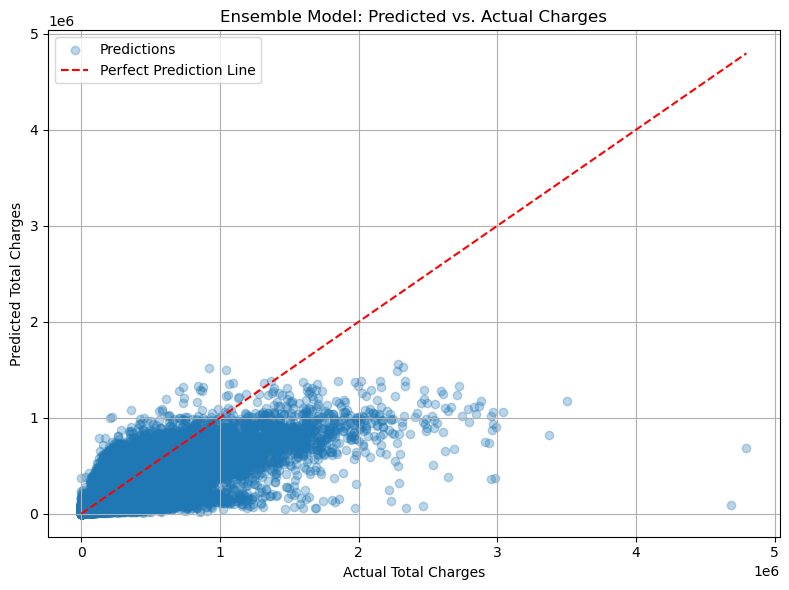

In [35]:
# Visualize ensemble model performance with a scatter plot
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_true, y_pred, alpha=0.3, label="Predictions")
plt.plot([0, y_true.max()], [0, y_true.max()], 'r--', label="Perfect Prediction Line")

plt.xlabel("Actual Total Charges")
plt.ylabel("Predicted Total Charges")
plt.title("Ensemble Model: Predicted vs. Actual Charges")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Ensemble Model: Predicted vs. Actual Charges

This scatter plot compares **predicted** total hospital charges to the **actual** charges across all patients using the ensemble model.

- Most points lie **below the red dashed line**, meaning the model tends to **underpredict high-cost cases**.
- The spread is **tight at lower charge values** (dense cluster near the origin), but becomes **wider** as charges increase — showing that prediction **variance grows with cost**.
- Some extreme outliers (charges > $2M) are **significantly underpredicted**, contributing to higher MAE.


### Decode Worst Residuals Sample

To analyze outliers meaningfully, we convert encoded columns (e.g. `county_encoded`) into readable labels using mapping files. This makes it easier to identify patterns across diagnosis, severity, or hospital region.

In [36]:
# Create residuals column
df_with_preds['residual'] = abs(df_with_preds['ensemble_prediction'] - df_with_preds['total_charges'])

# Load worst residuals sample
worst_2500 = pd.read_csv('../data/ensemble_worst_2500_residuals.csv')

# Load all mapping tables for decoding encoded categorical features
mapping_files = {
    'procedure': 'procedure_mapping.csv',
    'county': 'county_mapping.csv',
    'age_group': 'age_group_mapping.csv',
    'gender': 'gender_mapping.csv',
    'severity': 'severity_mapping.csv',
    'admission': 'admission_type_mapping.csv',
    'payment_type': 'payment_type_mapping.csv',
    'diagnosis': 'diagnosis_mapping.csv'
}

# Load each mapping into a dictionary
mappings = {key: pd.read_csv(f"../data/{file}") for key, file in mapping_files.items()}

# Merge encoded columns with their corresponding label mappings
labeled = (
    worst_2500
    .merge(mappings['procedure'], on='procedure_encoded', how='left')
    .merge(mappings['county'], on='county_encoded', how='left')
    .merge(mappings['age_group'], on='age_group_encoded', how='left')
    .merge(mappings['gender'], on='gender_encoded', how='left')
    .merge(mappings['severity'], on='severity_encoded', how='left')
    .merge(mappings['admission'], on='admission_encoded', how='left')
    .merge(mappings['payment_type'], on='payment_type_encoded', how='left')
    .merge(mappings['diagnosis'], on='diagnosis_encoded', how='left')
    .copy()  
)

In [ ]:
# Format currency values 
labeled[
    ['total_charges', 'ensemble_prediction', 'residual', 
     'ccs_procedure_description', 'hospital_county', 'age_group', 
     'gender', 'severity', 'admission_type', 'payment_type']
].head().style.format({
    'total_charges': '${:,.0f}',
    'ensemble_prediction': '${:,.0f}',
    'residual': '${:,.0f}'
})

,total_charges,ensemble_prediction,residual,ccs_procedure_description,hospital_county,age_group,gender,severity,admission_type,payment_type
0,"$4,687,204","$91,255","$4,595,949",PERC TRANSLUM COR ANGIO,Nassau,70 or Older,M,Major,Emergency,Medicare
1,"$4,795,126","$780,763","$4,014,363",ELECTROENCEPHALOGRAM,Manhattan,0 to 17,M,Major,Emergency,Private Health Insurance
2,"$3,374,149","$857,256","$2,516,892",UP GASTRO ENDOSC/BIOPSY,Westchester,18 to 29,M,Extreme,Elective,Private Health Insurance
3,"$2,981,284","$498,942","$2,482,341",COLORECTAL RESECTION,Manhattan,50 to 69,M,Minor,Urgent,Medicaid
4,"$2,953,401","$490,709","$2,462,692",OTHER OR THER NERV SYS,Manhattan,0 to 17,M,Minor,Emergency,Other


### High-Error Procedures
Goal: Find which procedures consistently have the highest prediction errors.

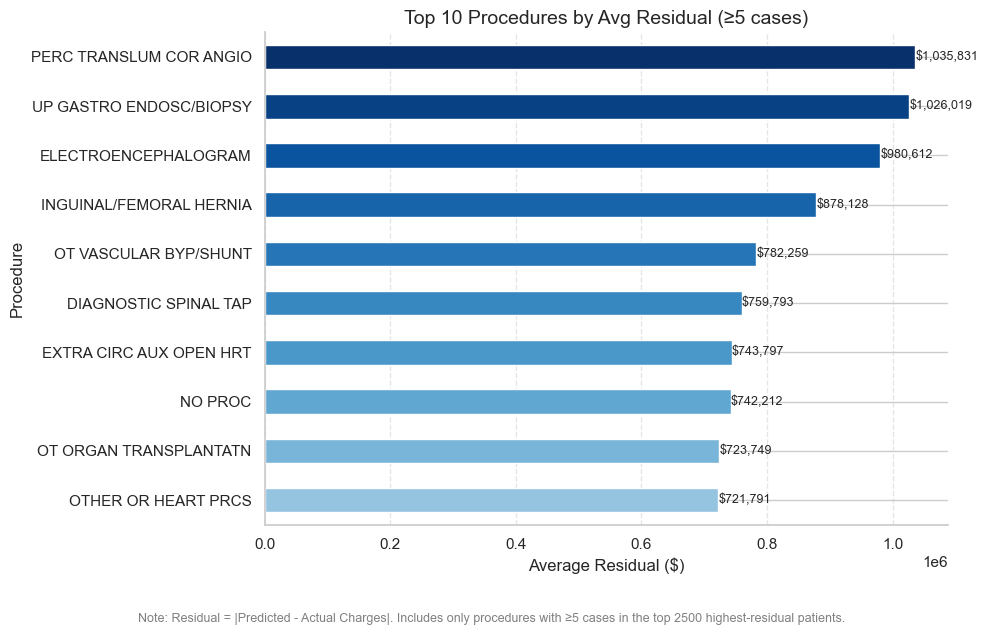

In [92]:
# Sort and plot horizontal bar chart with improved style
ax = proc_residuals['avg_residual'].sort_values(ascending=True).plot.barh(
    figsize=(10, 6), 
    color=plt.cm.Blues(np.linspace(0.4, 1, len(proc_residuals)))
)

# Add average residual values next to bars
for i, value in enumerate(proc_residuals['avg_residual'].sort_values()):
    ax.text(value + 500, i, f"${value:,.0f}", va='center', fontsize=9)

# Styling
plt.title('Top 10 Procedures by Avg Residual (≥5 cases)', fontsize=14)
plt.xlabel('Average Residual ($)', fontsize=12)
plt.ylabel('Procedure', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.5)
ax.spines[['top', 'right']].set_visible(False)

# Footnote
plt.figtext(0.5, -0.05,
    "Note: Residual = |Predicted - Actual Charges|. Includes only procedures with ≥5 cases in the top 2500 highest-residual patients.",
    wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

 ### Top Procedures with Highest Prediction Errors

This chart shows the **top 10 procedures** with the **largest average residuals** (errors between predicted and actual charges) from the worst 2,500 cases. Only procedures with **5+ cases** are included.

**Key Takeaways:**
- Highest errors:  
  • `PERC TRANSLUM COR ANGIO`: ~$1.04M  
  • `UP GASTRO ENDOSC/BIOPSY`: ~$1.03M  
  • `EEG`: ~$981K
- Errors are concentrated in **cardiac, GI, and neuro procedures**.
- The model struggles most with **complex or high-cost procedures**, and also with **missing codes** like `"NO PROC"`.

Suggests value in **procedure-specific tuning** or **richer clinical features**.

This chart shows the **top 10 procedures** with the highest average residuals among the 2,500 worst-predicted cases (only procedures with ≥5 occurrences included).

- **PERC TRANSLUM COR ANGIO** and **UP GASTRO ENDOSC/BIOPSY** had the largest underpredictions, with average residuals close to $1 million.

- Several high-error procedures, such as **ELECTROENCEPHALOGRAM** and **INGUINAL/FEMORAL HERNIA**, are common but variable in cost, possibly due to differences in setting (e.g., emergency vs. outpatient).

- **NO PROC** appearing in the top 10 suggests that missing or unrecorded procedures may confuse the model.



## County-Level Residuals
Goal: Identify regional/hospital-related patterns

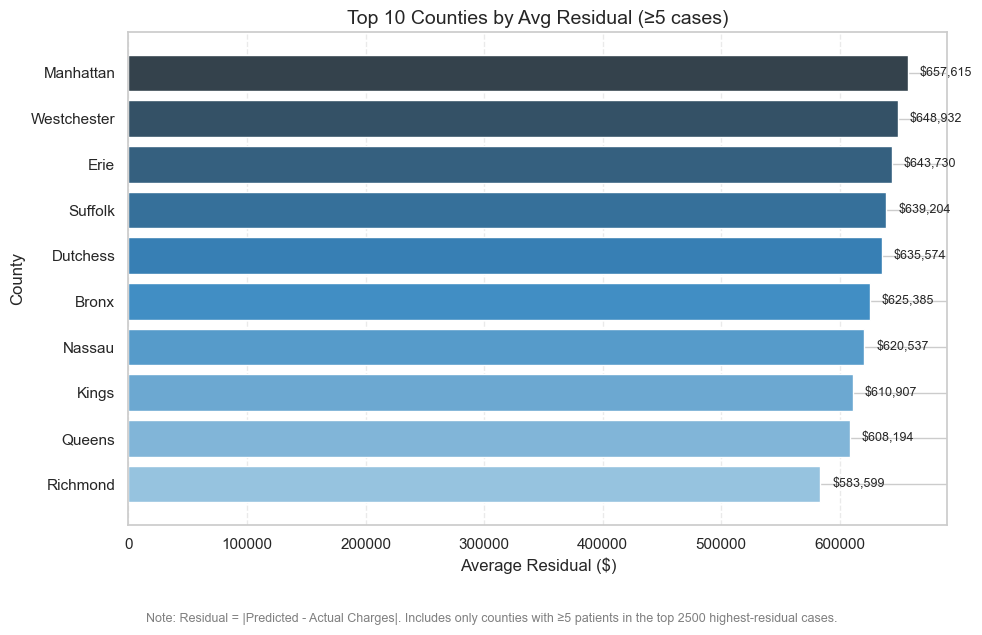

In [93]:
# Create bar chart
sorted_residuals = county_residuals['avg_residual'].sort_values()
colors = sns.color_palette("Blues_d", len(sorted_residuals))
plt.figure(figsize=(10, 6))
bars = plt.barh(sorted_residuals.index, sorted_residuals.values, color=colors)

# Add value labels
for bar in bars:
    width = bar.get_width()
    plt.text(width + 10000, bar.get_y() + bar.get_height()/2,
             f"${width:,.0f}", va='center', fontsize=9)

# Titles and labels
plt.title('Top 10 Counties by Avg Residual (≥5 cases)', fontsize=14)
plt.xlabel('Average Residual ($)', fontsize=12)
plt.ylabel('County', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.4)

# Footnote
plt.figtext(0.5, -0.05,
    "Note: Residual = |Predicted - Actual Charges|. Includes only counties with ≥5 patients in the top 2500 highest-residual cases.",
    wrap=True, horizontalalignment='center', fontsize=9, color='gray')

plt.tight_layout()
plt.show()

### Counties with Highest Prediction Errors

This chart highlights the **top 10 counties** with the largest average residuals (i.e., prediction errors) among the 2,500 worst-predicted cases. Each county had at least 5 high-error cases. 

**Key Takeaways:**  
The model consistently **underpredicts hospital charges** in urban and high-cost counties like **Manhattan**, **Westchester**, and **Erie**, suggesting that regional factors may drive unexpectedly high charges not fully captured by existing features.

Improving the model's sensitivity to **location-specific cost drivers** could reduce these large residuals.

## Residuals by Severity & LOS Group
Goal: See if model underperforms for complex/severe patients

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_14186/3225339876.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='severity', y='residual', data=labeled, palette='Blues')


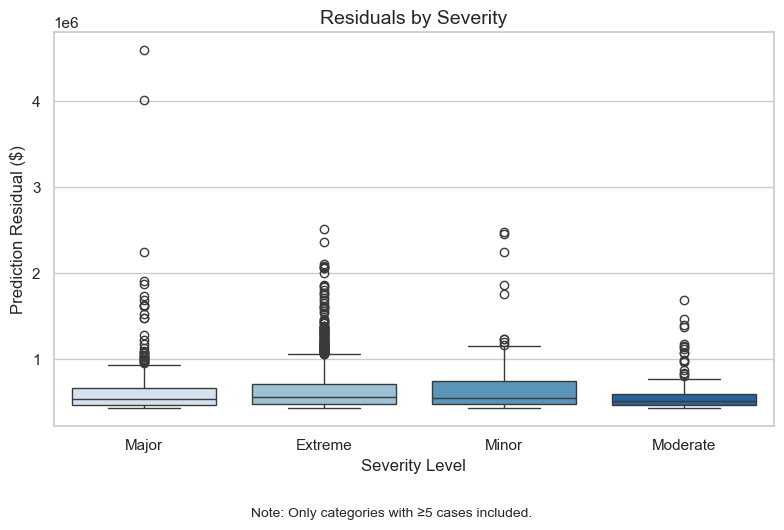

/var/folders/6z/l9wv3crd4n5bzgcrdd7vxq8m0000gn/T/ipykernel_14186/3225339876.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='los_group', y='residual', data=labeled, palette='Greens')


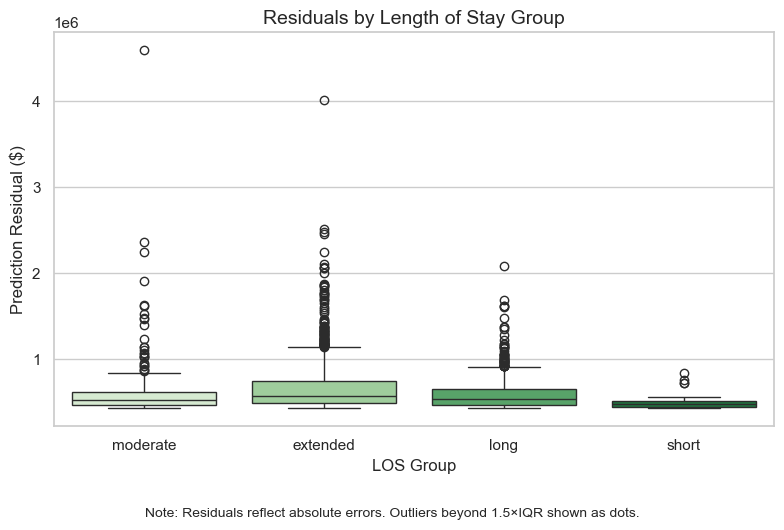

In [94]:
# Set a clean style
sns.set(style="whitegrid")

# Plot residuals by severity level
plt.figure(figsize=(8, 5))
sns.boxplot(x='severity', y='residual', data=labeled, palette='Blues')
plt.title("Residuals by Severity", fontsize=14)
plt.xlabel("Severity Level")
plt.ylabel("Prediction Residual ($)")
plt.figtext(0.5, -0.05, "Note: Only categories with ≥5 cases included.", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

# Plot residuals by length of stay group
plt.figure(figsize=(8, 5))
sns.boxplot(x='los_group', y='residual', data=labeled, palette='Greens')
plt.title("Residuals by Length of Stay Group", fontsize=14)
plt.xlabel("LOS Group")
plt.ylabel("Prediction Residual ($)")
plt.figtext(0.5, -0.05, "Note: Residuals reflect absolute errors. Outliers beyond 1.5×IQR shown as dots.", ha="center", fontsize=10)
plt.tight_layout()
plt.show()

### Residual Patterns by Severity and Length of Stay

- **Residuals increase with clinical severity**: Extreme and Major cases have the **widest spread** and **highest outliers**, suggesting greater modeling difficulty for complex patients.
- **Length of stay is predictive but noisy**: Extended and long-stay groups show **higher and more variable residuals**, while short stays are **tightly clustered** and better predicted.
- These trends **support segmentation**: Stratifying models by **severity** or **LOS** can help improve accuracy by capturing distinct cost dynamics.

## Interaction Feature - los_x_severity
**Goal:** Evaluate whether adding an interaction feature between **Length of Stay (LOS)** and **Severity** improves the model’s ability to capture complex patient charge patterns.


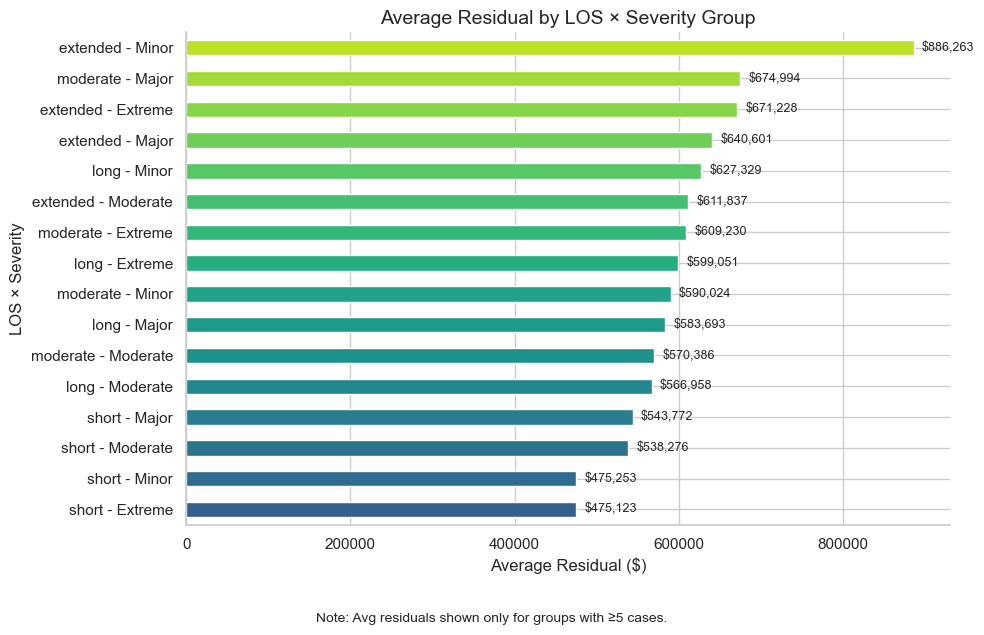

In [96]:
# Create readable labels for each LOS × Severity group
labeled["los_severity_label"] = labeled["los_group"] + " - " + labeled["severity"]

# Group by label and calculate average residuals
grouped_los_sev = (
    labeled.groupby("los_severity_label")
    .agg(avg_residual=("residual", "mean"), count=("residual", "size"))
    .query("count >= 5")  # Keep groups with at least 5 cases
    .sort_values(by="avg_residual", ascending=False)
)

# Plot average residuals by LOS × Severity group
fig, ax = plt.subplots(figsize=(10, 6))
bars = grouped_los_sev["avg_residual"].sort_values().plot.barh(
    ax=ax,
    color=plt.cm.viridis(np.linspace(0.3, 0.9, len(grouped_los_sev))),
)

# Add value labels
for i, value in enumerate(grouped_los_sev["avg_residual"].sort_values()):
    ax.text(value + 10000, i, f"${value:,.0f}", va="center", fontsize=9)

# Customize aesthetics
ax.set_title("Average Residual by LOS × Severity Group", fontsize=14)
ax.set_xlabel("Average Residual ($)", fontsize=12)
ax.set_ylabel("LOS × Severity", fontsize=12)
ax.spines[['top', 'right']].set_visible(False)

plt.figtext(0.5, -0.05,
            "Note: Avg residuals shown only for groups with ≥5 cases.",
            ha="center", fontsize=10)

plt.tight_layout()
plt.show()

### Average Residual by LOS × Severity Group

This bar chart shows how prediction error varies across combinations of **Length of Stay (LOS)** and **severity**. 

- **Highest residuals** were found in **extended stays** with **minor or extreme severity**, suggesting the model struggles most with unexpected costs in these outlier groups.
- **Short LOS groups** had the **lowest average residuals**, indicating better model performance for simpler, lower-cost cases.

## Residuals by Diagnoses


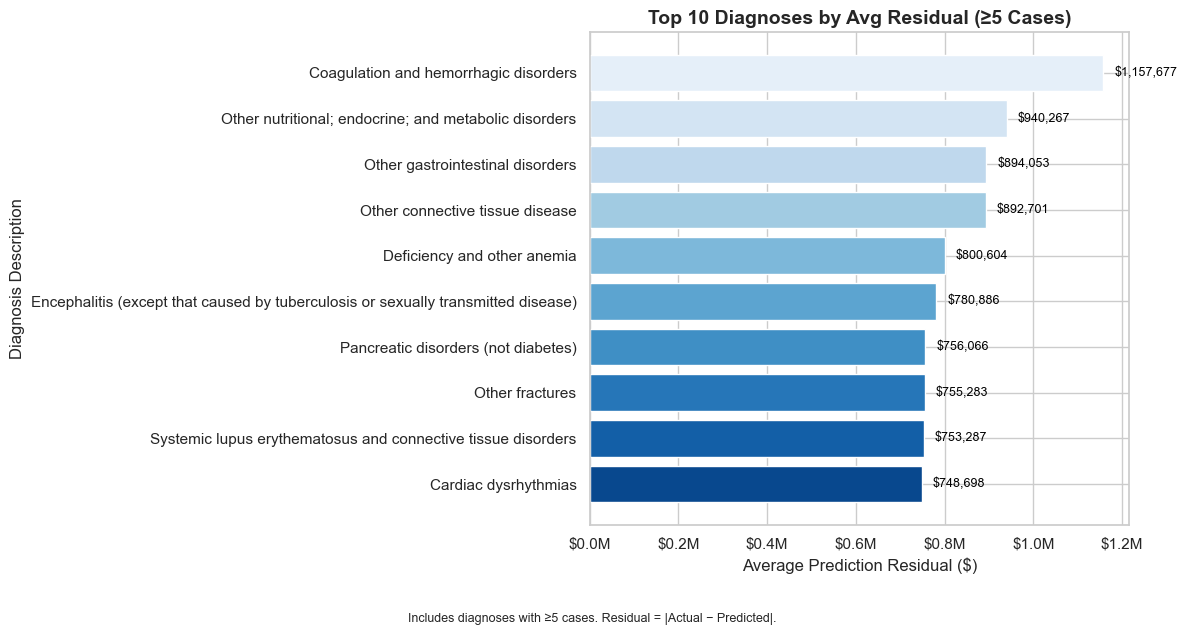

In [98]:
# Sort diagnosis residuals for clean plotting
sorted_diagnoses = diagnoses_residuals['avg_residual'].sort_values()

# Set figure and aesthetic style
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

# Create horizontal bar plot
bars = plt.barh(
    sorted_diagnoses.index,
    sorted_diagnoses.values,
    color=sns.color_palette("Blues_r", len(sorted_diagnoses))
)

# Format x-axis as dollar amounts in millions
plt.gca().xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e6:.1f}M'))

# Add text labels to the end of each bar
for bar in bars:
    width = bar.get_width()
    plt.text(
        width + 25_000,
        bar.get_y() + bar.get_height() / 2,
        f'${width:,.0f}',
        va='center',
        ha='left',
        fontsize=9,
        color='black'
    )

# Set plot labels and title
plt.title('Top 10 Diagnoses by Avg Residual (≥5 Cases)', fontsize=14, weight='bold')
plt.xlabel('Average Prediction Residual ($)', fontsize=12)
plt.ylabel('Diagnosis Description', fontsize=12)

# Adjust layout for readability
plt.subplots_adjust(left=0.35)

plt.figtext(
    0.5, -0.05,
    "Includes diagnoses with ≥5 cases. Residual = |Actual − Predicted|.",
    ha="center", fontsize=9
)


plt.tight_layout()
plt.show()

### Top 10 Diagnoses by Average Prediction Residual

This chart highlights diagnoses with the **largest average prediction errors**, suggesting potential gaps in model accuracy for these groups. 

- **Coagulation and hemorrhagic disorders** had the **highest residuals**, averaging over **$1.15M**.
- **Nutritional, metabolic, gastrointestinal, and connective tissue disorders** also showed residuals exceeding **$890K**.
- All diagnoses shown had **≥5 cases**, ensuring reliable average estimates.

**Interpretation**: These underpredicted diagnoses may involve complex or variable care costs that are not fully captured by current model features.

##  Residuals by Payment Type

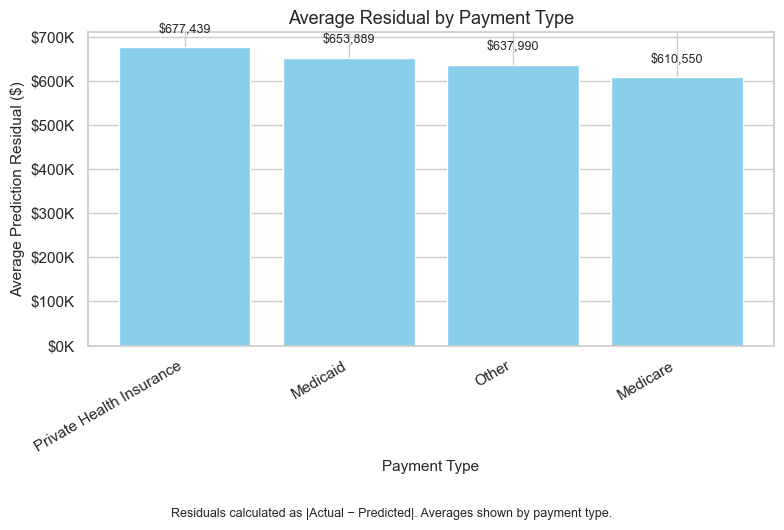

In [99]:
# Group by payment type and calculate average residuals
pay_residuals = (
    labeled.groupby('payment_type')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .sort_values(by='avg_residual', ascending=False)
)

# Set up figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Bar plot
bars = ax.bar(pay_residuals.index, pay_residuals['avg_residual'], color='skyblue')

# Format y-axis to show thousands (e.g., $800K)
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f'${x/1e3:.0f}K'))

# Add bar labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, height + 25000, f'${height:,.0f}', 
            ha='center', va='bottom', fontsize=9)

# Labels and title
ax.set_title('Average Residual by Payment Type', fontsize=13)
ax.set_xlabel('Payment Type', fontsize=11)
ax.set_ylabel('Average Prediction Residual ($)', fontsize=11)
ax.set_xticks(range(len(pay_residuals.index)))
ax.set_xticklabels(pay_residuals.index, rotation=30, ha='right')

plt.figtext(
    0.5, -0.05,
    "Residuals calculated as |Actual − Predicted|. Averages shown by payment type.",
    ha="center", fontsize=9
)

plt.tight_layout()
plt.show()

### Average Residual by Payment Type

Private health insurance patients had the highest average prediction errors (~$677K), followed by Medicaid and Other. Medicare had the lowest average residuals (~$611K), suggesting better model performance for those cases.

## SHAP for Extended - Minor

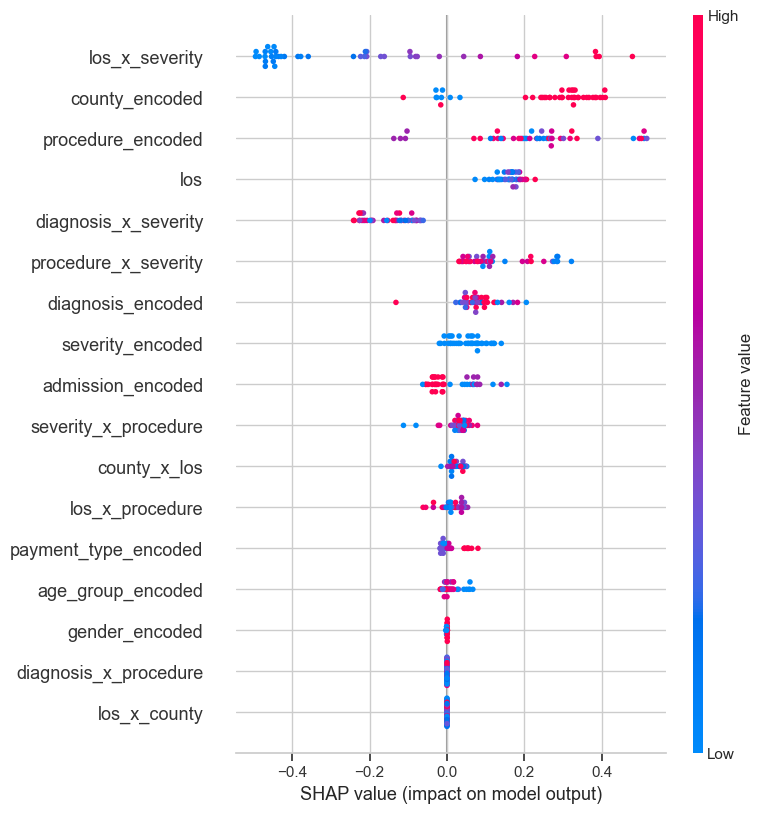

In [ ]:
# Create missing interaction features in the labeled dataset
labeled['diagnosis_x_severity'] = labeled['diagnosis_encoded'] * labeled['severity_encoded']
labeled['procedure_x_severity'] = labeled['procedure_encoded'] * labeled['severity_encoded']
labeled['diagnosis_x_procedure'] = labeled['diagnosis_encoded'] * labeled['procedure_encoded']
labeled['county_x_los'] = labeled['county_encoded'] * labeled['los']

# Define input features expected by the model
model_input_columns = [
    'gender_encoded', 'age_group_encoded', 'severity_encoded',
    'admission_encoded', 'payment_type_encoded', 'diagnosis_encoded',
    'procedure_encoded', 'county_encoded', 'los',
    'los_x_severity', 'los_x_procedure', 'severity_x_procedure',
    'diagnosis_x_severity', 'procedure_x_severity',
    'diagnosis_x_procedure', 'county_x_los', 'los_x_county'
]

# Filter for the subgroup: Extended stays with Minor severity
target_group = labeled[
    (labeled['los_group'] == 'extended') &
    (labeled['severity'] == 'Minor')
]

# Prepare input features for SHAP
X = target_group[model_input_columns]

# Load SHAP explainer and compute values
explainer = shap.Explainer(model)
shap_values = explainer(X)


shap.summary_plot(shap_values, X)

### SHAP Summary Plot: Extended LOS + Minor Severity Patients

This SHAP summary plot explains which features most strongly influenced the model’s predictions for patients with **extended length of stay and minor severity**.

- **Top Drivers**: 
  - `los_x_severity`, `county_encoded`, and `procedure_encoded` had the highest impact.
  - Interaction features like `diagnosis_x_severity` and `procedure_x_severity` also contributed meaningfully.

- **Interpretation**:
  - **Positive SHAP values** → pushed predictions higher (overpredictions).
  - **Negative SHAP values** → lowered predictions (underpredictions).
  - **Color scale** indicates the feature’s value for each point (red = high, blue = low).

This visualization helps pinpoint where the model may be systematically over- or under-predicting for this patient group.

 ## Extended-Major Group


SHAP Analysis for Procedure: ELECTROENCEPHALOGRAM


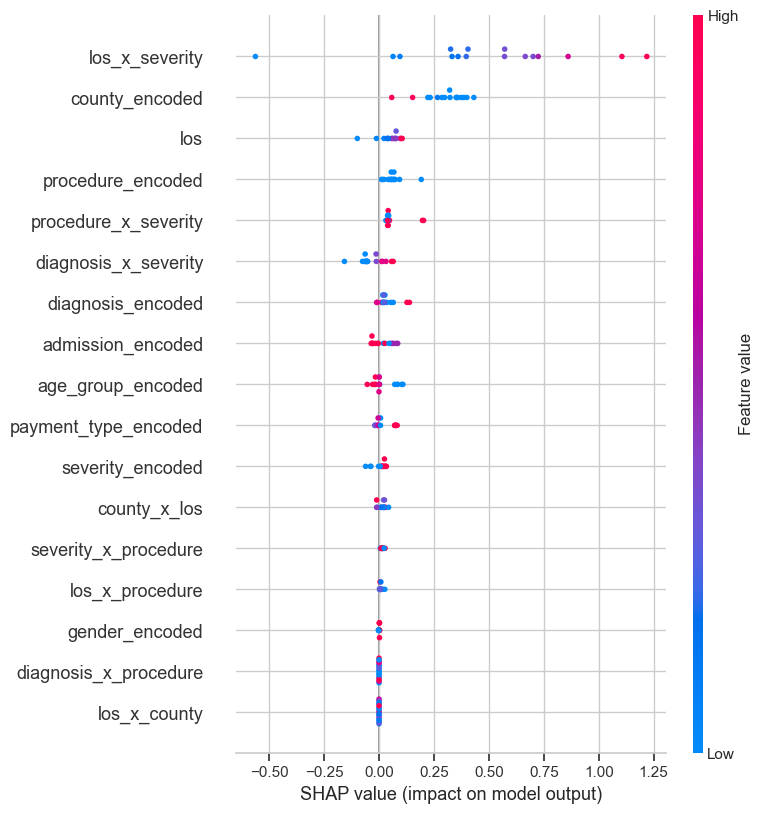


SHAP Analysis for Procedure: OTHER OR HEART PRCS


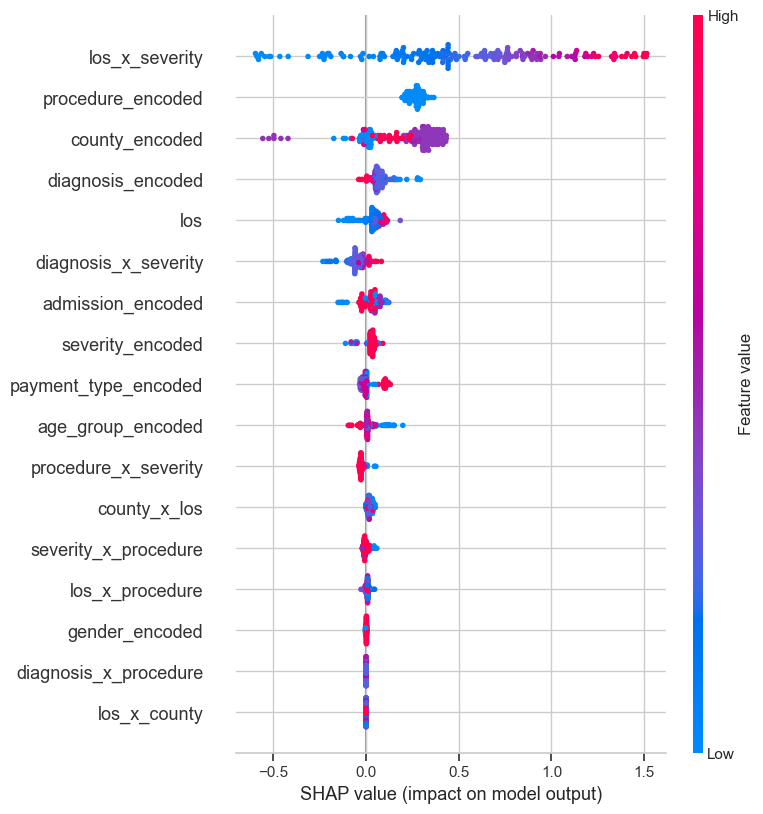


SHAP Analysis for Procedure: OT OR PRCS VES NOT HEAD


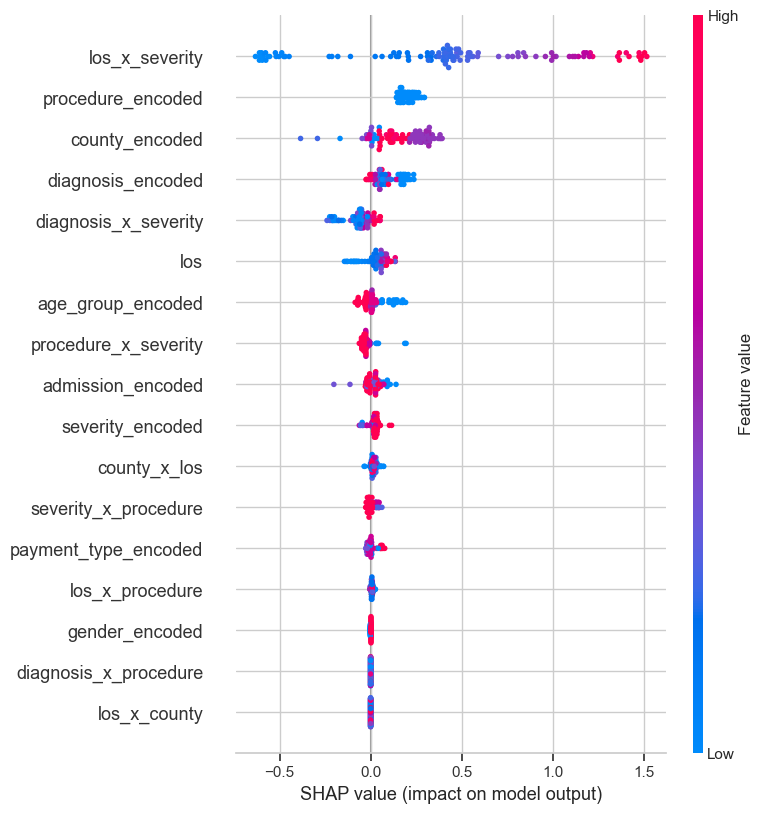


SHAP Analysis for Procedure: OT ORGAN TRANSPLANTATN


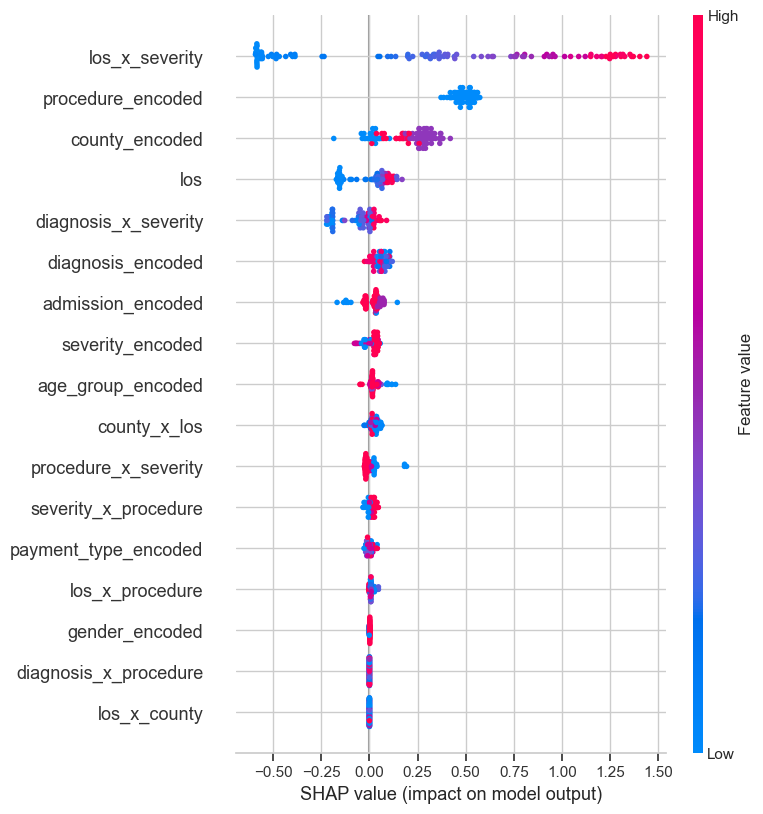


SHAP Analysis for Procedure: BONE MARROW TRANSPLANT


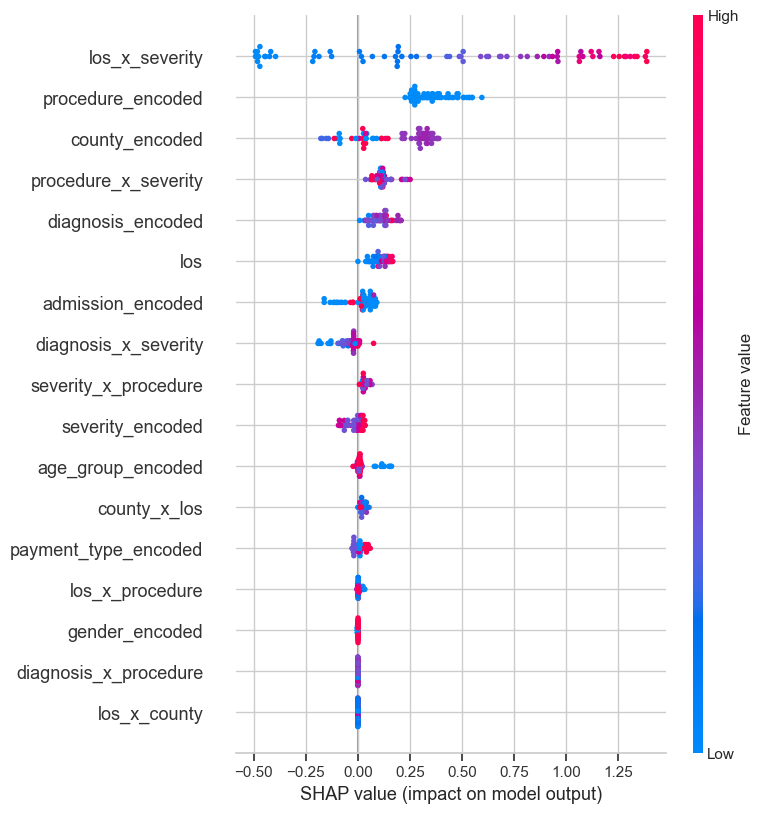


SHAP Analysis for Procedure: TRACHEOSTOMY; TEMP/PERM


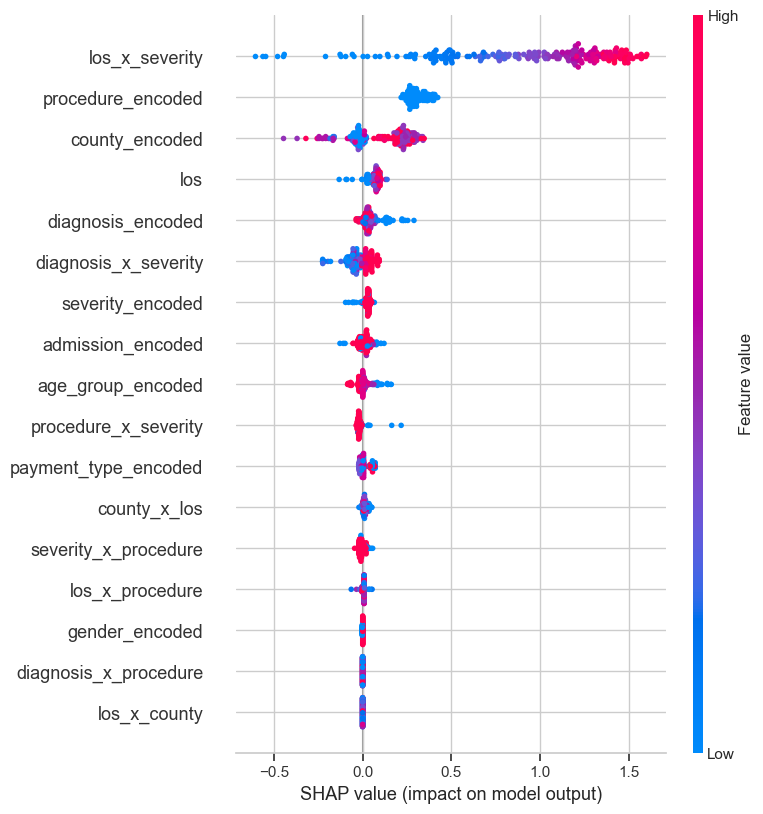


SHAP Analysis for Procedure: OTHER THERAPEUTIC PRCS


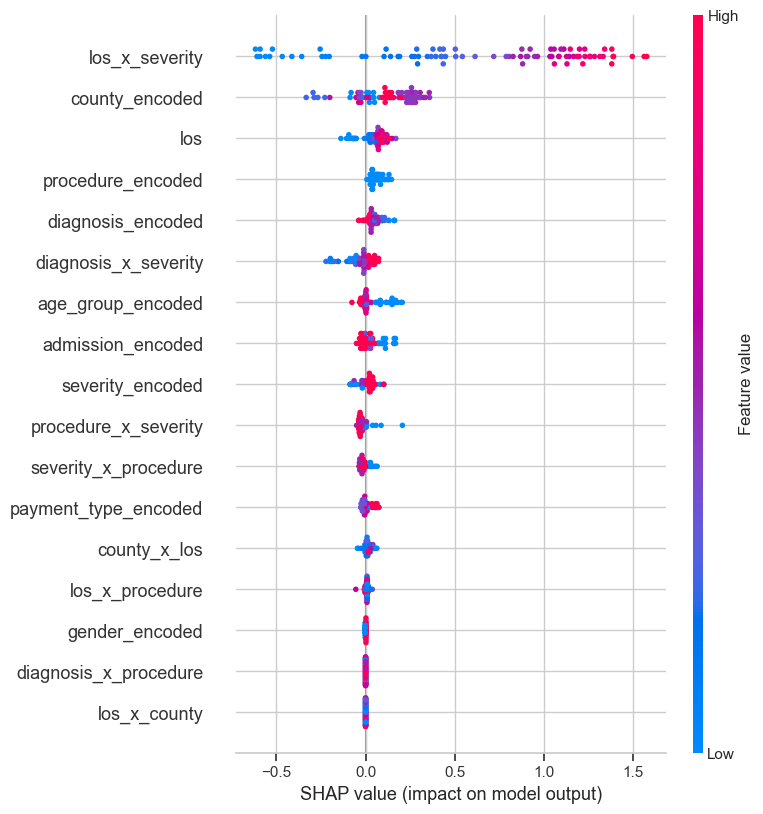


SHAP Analysis for Procedure: RESP INTUB/MECH VENTIL


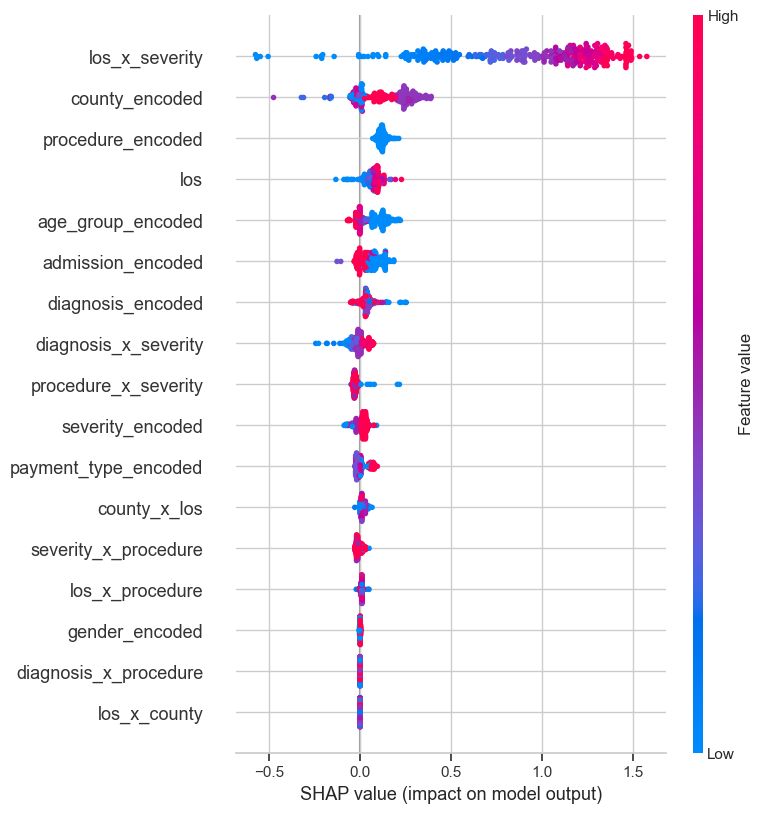


SHAP Analysis for Procedure: HEART VALVE PRCS


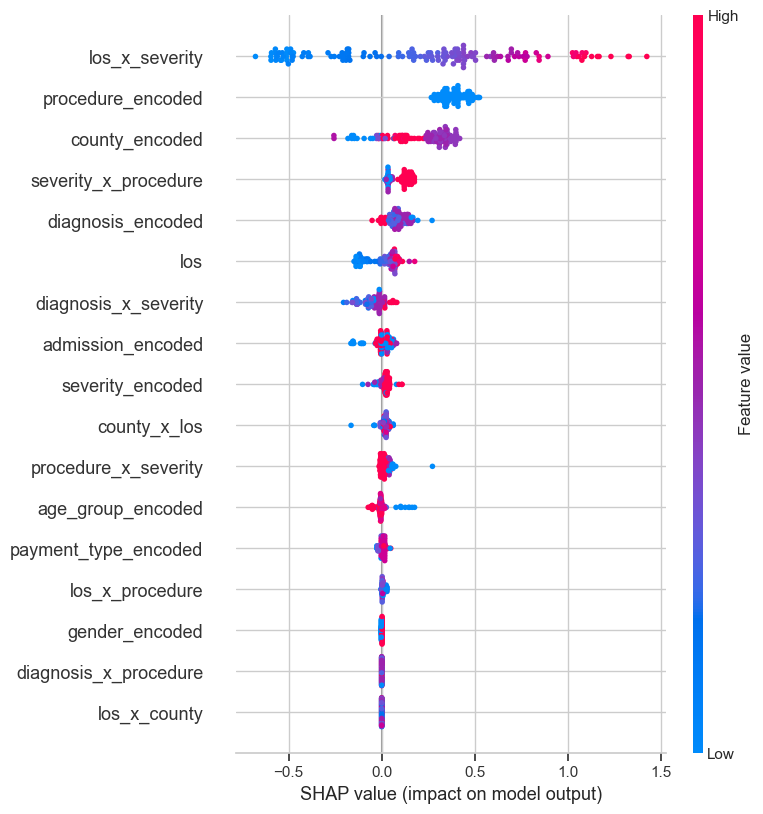


SHAP Analysis for Procedure: ENTERAL/PARENTERAL NUTR


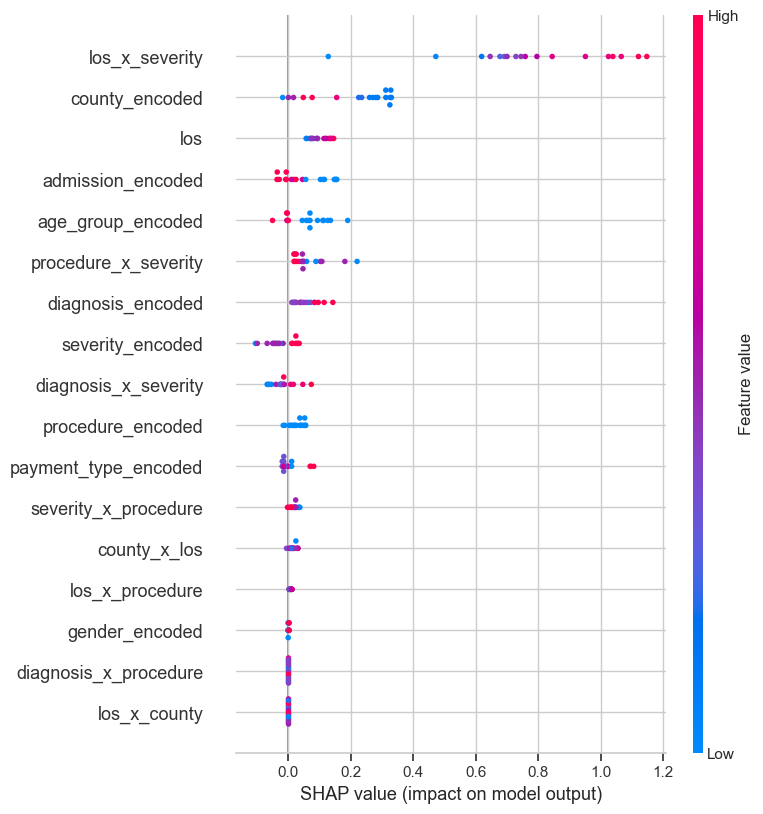

In [91]:
# Subset to patients with extended length of stay and major severity
target_group = labeled[
    (labeled['los_group'] == 'extended') & 
    (labeled['severity'] == 'Major')
]

# Identify top 10 procedures by average residual (min 5 cases)
top_procs_df = (
    target_group
    .groupby('ccs_procedure_description')
    .agg(avg_residual=('residual', 'mean'), count=('residual', 'size'))
    .query('count >= 5')
    .sort_values(by='avg_residual', ascending=False)
    .head(10)
)

# List of top procedure names 
top_procs = top_procs_df.index.tolist()

# Loop through each top procedure and compute SHAP values
for proc in top_procs:
    print(f"\nSHAP Analysis for Procedure: {proc}")
    
    # Subset to only that procedure within labeled data
    subset = labeled[labeled['ccs_procedure_description'] == proc]
    
    # Extract model inputs
    X = subset[model_input_columns]
    
    # Compute SHAP values
    shap_values = explainer(X)
    
    shap.summary_plot(shap_values, X, plot_type='dot', show=True)

### SHAP Summary Plots: Top 10 Procedures (Extended LOS + Major Severity)

The following SHAP plots visualize model explainability for the **top 10 procedures** with the **highest average residuals** among patients who experienced **extended length of stay** and had **major severity** conditions.

- **Goal:** Identify which input features most influence prediction error for each procedure.
- **Method:** For each procedure (with ≥5 cases), SHAP values were computed using the trained LightGBM model to understand **feature impact**.
- **Interpretation:** 
  - Each point represents a patient.
  - Colors reflect feature values (red = high, blue = low).
  - Feature order indicates overall impact on model output.

This breakdown helps uncover **why the model over- or under-predicts charges** for specific procedures. It also guides **targeted model refinement** by highlighting high-impact drivers for each outlier group.